In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set()

df = pd.read_csv("data/data.csv")
df.head()

,top_n,rank,true_value,params,ppf025,ppf975,sim_no,estimator,data_file
0,1,0,0.045,0.131315,-1.004121,0.579467,0,conditional,movers
1,2,0,0.045,0.222837,-0.569538,0.595267,0,conditional,movers
2,2,1,0.024,-0.356603,-3.452920,0.504527,0,conditional,movers
3,3,0,0.045,0.254296,-0.422476,0.600630,0,conditional,movers
4,3,1,0.024,-0.090065,-1.978997,0.541278,0,conditional,movers


In [2]:
df["pr_overestimate"] = (df.params > df.true_value)
df["coverage"] = (df.ppf025 < df.true_value) & (df.true_value < df.ppf975)
df["len_ci"] = df.ppf975 - df.ppf025

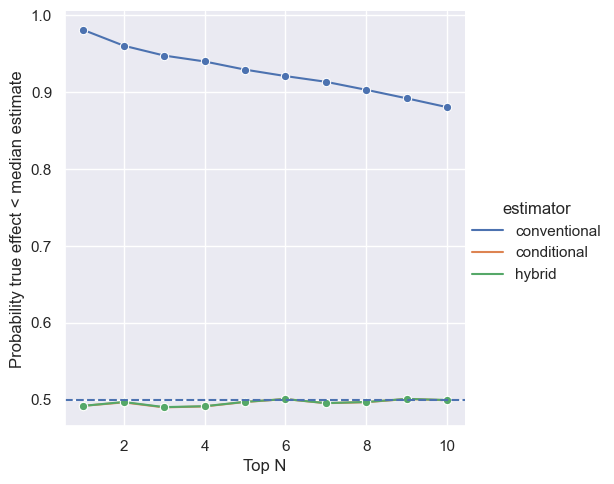

In [6]:
grid = sns.relplot(
    data=df[df.estimator != "projection"],
    x="top_n",
    y="pr_overestimate",
    hue="estimator",
    hue_order=["conventional", "conditional", "hybrid"],
    kind="line",
    ci=None,
    marker="o"
)
for ax in grid.axes[0]:
    ax.axhline(.5, linestyle="--")
grid.set_ylabels("Probability true effect < median estimate")
grid.set_xlabels("Top N")
grid.fig.savefig("plots/pr_overestimate.png")
plt.show()

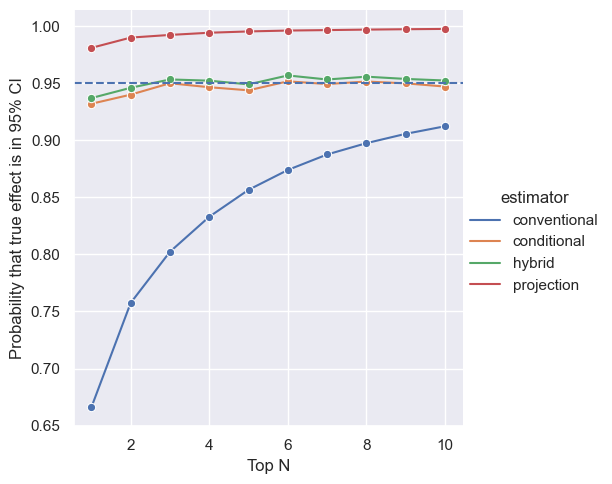

In [4]:
grid = sns.relplot(
    data=df,
    x="top_n",
    y="coverage",
    hue="estimator",
    hue_order=["conventional", "conditional", "hybrid", "projection"],
    kind="line",
    ci=None,
    marker="o"
)
for ax in grid.axes[0]:
    ax.axhline(.95, linestyle="--")
grid.set_ylabels("Probability that true effect is in 95% CI")
grid.set_xlabels("Top N")
grid.fig.savefig("plots/coverage.png")
plt.show()

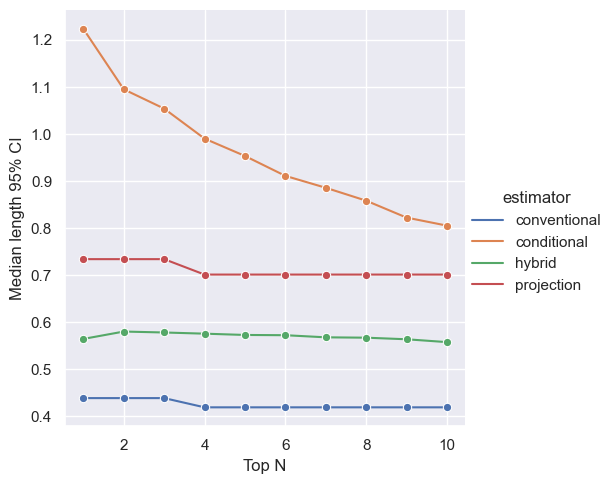

In [5]:
grid = sns.relplot(
    data=df,
    x="top_n",
    y="len_ci",
    hue="estimator",
    hue_order=["conventional", "conditional", "hybrid", "projection"],
    ci=None,
    kind="line",
    marker="o",
    estimator=lambda x: np.quantile(x, .5)
)
grid.set_ylabels("Median length 95% CI")
grid.set_xlabels("Top N")
grid.fig.savefig("plots/len_ci.png")
plt.show()

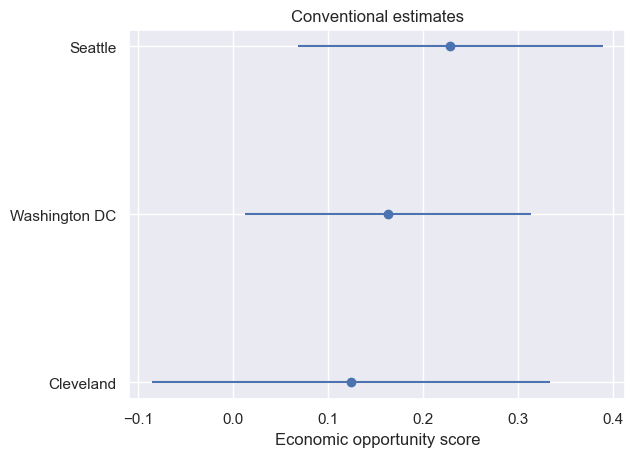

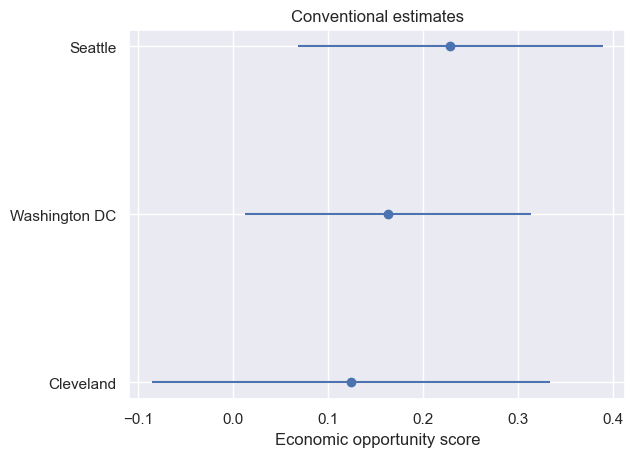

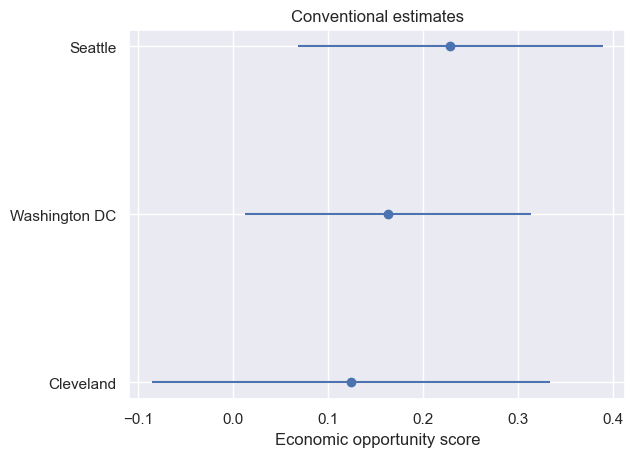

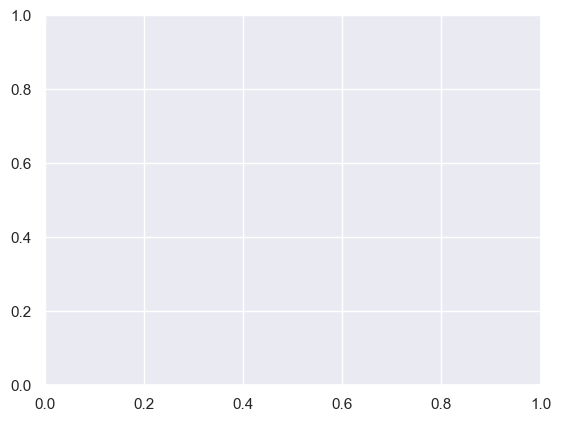

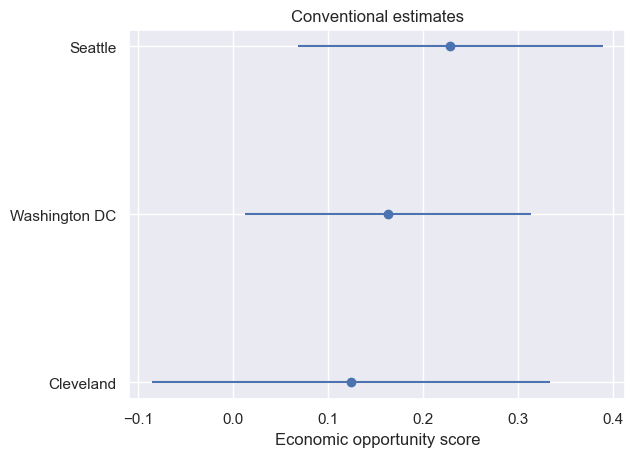

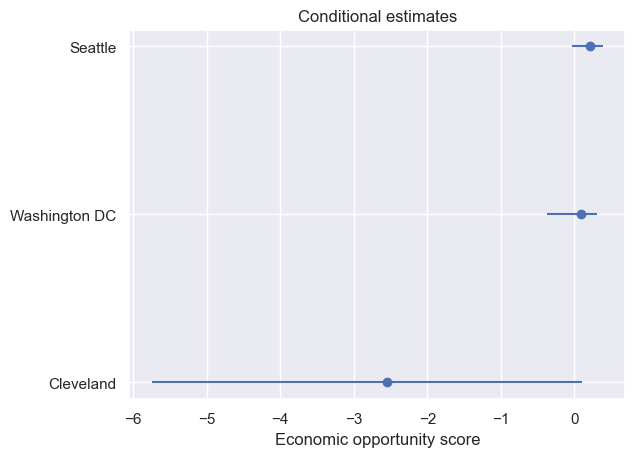

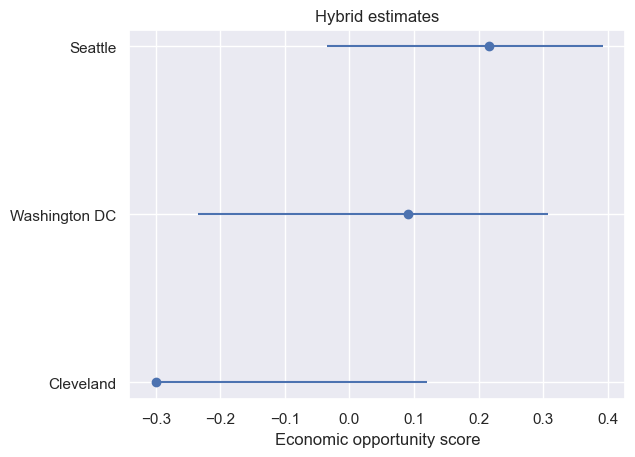

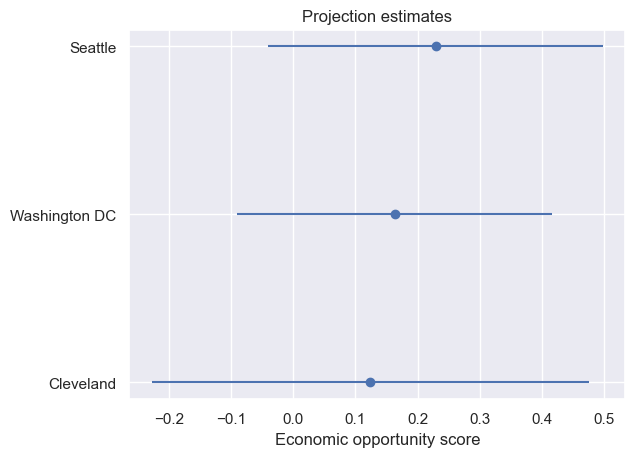

In [41]:
import matplotlib.pyplot as plt

from conditional_inference.bayes.classic import LinearClassicBayes
from conditional_inference.rqu import RQU

DATA_FILE = "../losers-empirical/movers.csv"
TOP_N = 3

estimates = {}

conventional_model = LinearClassicBayes.from_csv(DATA_FILE, prior_cov=np.inf)
argsort = np.argsort(-conventional_model.mean)
cols = argsort[:TOP_N]
estimates["Conventional"] = conventional_model.fit(cols=cols)

rqu_model = RQU.from_csv(DATA_FILE)
estimates["Conditional"] = rqu_model.fit(cols=cols, rank=np.arange(TOP_N))
estimates["Hybrid"] = rqu_model.fit(cols=cols, rank=np.arange(TOP_N), beta=.005)
estimates["Projection"] = rqu_model.fit(cols=cols, projection=True)

for title, results in estimates.items():
    fig = plt.figure()
    ax = fig.add_subplot()
    results.point_plot(title=f"{title} estimates", yname="Economic opportunity score", ax=ax)
    fig.savefig(f"plots/{title.lower()}.png", bbox_inches="tight")

plt.show()